In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
force_data = pd.read_csv("../dataset/GP1_0.6_force.csv")
marker_data = pd.read_csv("../dataset/GP1_0.6_marker.csv")

# Combine force and marker data
combined_data = pd.concat([force_data, marker_data], axis=1)


### Code Clearning

In [3]:
# Check for missing values
# print("Missing values in combined data:\n", combined_data.isnull().sum())
# # Check for duplicates
# print("\nDuplicate rows in combined data:", combined_data.duplicated().sum())

# Drop rows with missing values
combined_data.dropna(inplace=True)

# Remove duplicates
combined_data = combined_data.drop_duplicates()


### Generate Synthetic Labels for Gait Phases
Since we lack actual gait phase labels, we generate synthetic labels (Stance, Swing, Toe-off) for demonstration:

In [4]:
np.random.seed(42)
gait_phases = ['Stance', 'Swing', 'Toe-off']
combined_data['gait_phase'] = np.random.choice(gait_phases, size=combined_data.shape[0])

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(combined_data['gait_phase'])

# Convert labels to categorical format for LSTM
labels_categorical = to_categorical(labels)


In [5]:
labels

array([2, 0, 2, ..., 2, 0, 1])

In [6]:
labels_categorical

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

### Preprocessing

In [7]:
# Separate features and scale them
features = combined_data.drop('gait_phase', axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reshape data for LSTM: (samples, timesteps, features)
# Here, each sample is treated as a single timestep for simplicity
X = features_scaled.reshape(features_scaled.shape[0], 1, features_scaled.shape[1])
y = labels_categorical

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
X

array([[[ 4.11447239e-02, -2.50482941e-01,  9.66759800e-01, ...,
         -9.34959383e-01, -1.00930963e+00, -7.41508604e-01]],

       [[ 4.11447239e-02, -2.33545968e-01,  9.66759800e-01, ...,
         -9.37471779e-01, -1.01074608e+00, -7.45233240e-01]],

       [[ 4.11447239e-02, -2.16940957e-01,  9.66759800e-01, ...,
         -9.39918060e-01, -1.01232616e+00, -7.49084135e-01]],

       ...,

       [[-1.94188526e-02,  4.64328399e-02, -1.69488627e+00, ...,
         -7.24579261e-01, -7.86589293e-01, -7.04704146e-01]],

       [[-9.41122076e-03,  4.64328399e-02, -1.69190263e+00, ...,
         -7.26099922e-01, -7.87810269e-01, -7.05209182e-01]],

       [[ 6.15264237e-04,  4.64328399e-02, -1.68879966e+00, ...,
         -7.27356120e-01, -7.88887600e-01, -7.05714217e-01]]])

 ### Build and Train the LSTM Model

In [9]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3475 - loss: 1.1022 - val_accuracy: 0.3393 - val_loss: 1.0984
Epoch 2/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3581 - loss: 1.0968 - val_accuracy: 0.3423 - val_loss: 1.0994
Epoch 3/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3560 - loss: 1.0964 - val_accuracy: 0.3458 - val_loss: 1.0988
Epoch 4/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3631 - loss: 1.0979 - val_accuracy: 0.3500 - val_loss: 1.1000
Epoch 5/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3714 - loss: 1.0948 - val_accuracy: 0.3470 - val_loss: 1.0992
Epoch 6/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3651 - loss: 1.0953 - val_accuracy: 0.3464 - val_loss: 1.1008
Epoch 7/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3774 - loss: 1.0937 - val_accuracy: 0.3458 - val_loss: 1.1000
Epoch 8/20
210/210 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3761 - loss: 1.0920 - val_accuracy: 0.

### Evaluation

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:\n", conf_matrix)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes))



Test Accuracy: 0.33
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Confusion Matrix:
 [[225 473 568]
 [221 487 504]
 [209 426 487]]

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.18      0.23      1266
           1       0.35      0.40      0.37      1212
           2       0.31      0.43      0.36      1122

    accuracy                           0.33      3600
   macro avg       0.34      0.34      0.32      3600
weighted avg       0.34      0.33      0.32      3600



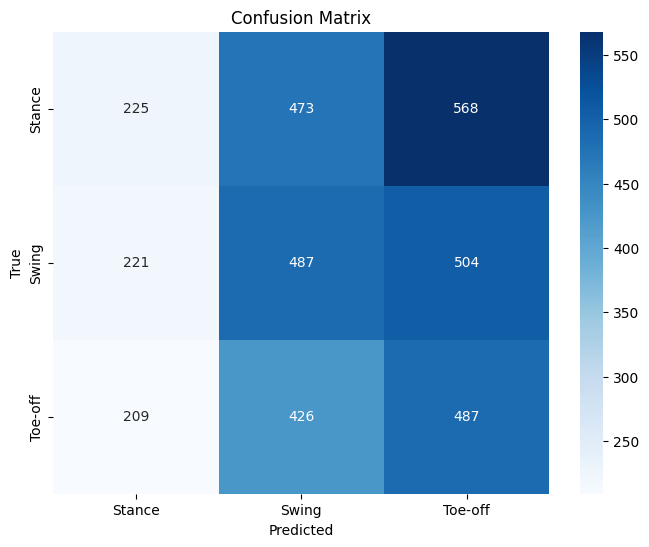

In [12]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=gait_phases, yticklabels=gait_phases)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

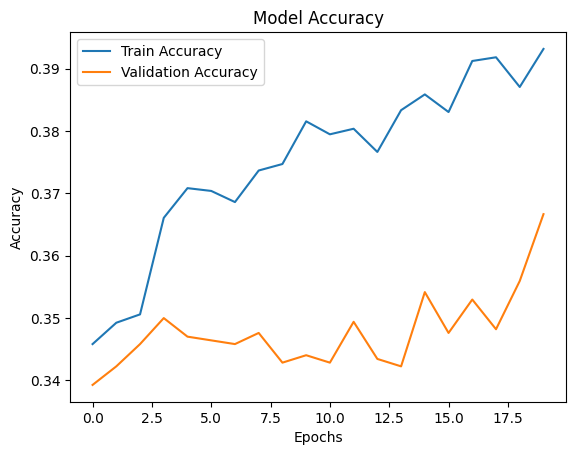

In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


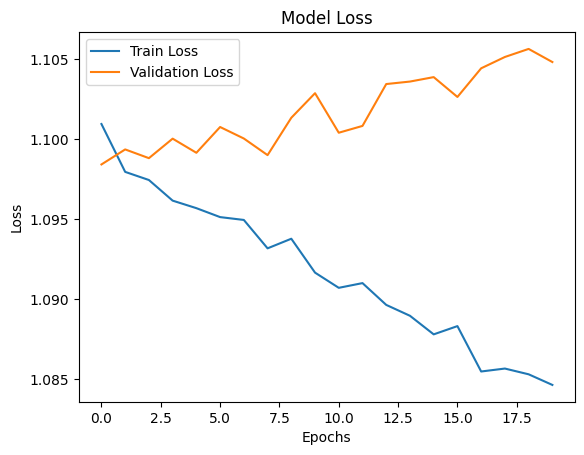

In [14]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()